## Demonstration of Spoken Digits Classification using LSTMs

This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Data-Driven Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).

This notebook demonstrates the classification of recorded spoken digits using the [AudioMNIST](https://github.com/soerenab/AudioMNIST) dataset. Please download/clone the dataset into the `data/` directory before executing this notebook. The model consists of a recurrent neural network (RNN) built from long short-term memory (LSTM) cells. Hereby Mel-Frequency Cepstral Coefficients (MFCCs) are used as two-dimensional features.

In [1]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

from librosa.feature import mfcc

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, Activation, Flatten, MaxPooling2D, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
path = '../data/AudioMNIST/data/**/'  # path to dataset

### Load Dataset

The AudioMNIST consists of a series of wav files containing recordings of the single spoken digits `0-9` for different individuals. Each digit has been recorded multiple times for each individual. In the following, all samples in the database are loaded, normalized and truncated to a common length.

In [3]:
def load_examples(path):

    X = list()
    Y = list()

    audiofiles = glob.glob(path, recursive=True)
    for filepath in audiofiles:
        x, fs = sf.read(filepath)
        x = x / np.max(np.abs(x))
        X.append(x)
        Y.append(int(os.path.basename(filepath)[0]))

    return X, Y, fs


# load examples
X_raw, Y, fs = load_examples(path + '*.wav')

# determine maximum length of the examples
lengths = [len(x) for x in X_raw]
F = np.max(lengths)

# append zeros to examples to equalize lengths
X_raw = [np.concatenate((sample, np.zeros(F - len(sample))))
         for sample in X_raw]
X_raw = np.array(X_raw)
Y = np.array(Y)

# one-hot encoding of class labels
Y1h = to_categorical(Y, 10)

In [4]:
print('Total number of examples: {}'.format(len(X_raw)))
print('Number of samples per example: {}'.format(F))

Total number of examples: 30000
Number of samples per example: 47998


### Feature Extraction

Now the MFCCs for each example are computed.

In [5]:
X = [mfcc(y=sample, sr=fs, htk=True) for sample in X_raw]
X = np.array(X)
X = np.transpose(X, axes=(0,2,1))  # (batch, time-steps, features) for LSTM layer

print('Total number of examples: {}'.format(X.shape[0]))
print('Dimension of feature vectors: {}'.format(X.shape[1:]))

Total number of examples: 30000
Dimension of feature vectors: (94, 20)


### Define and Train the Model

The model is defined as a concatenation of an input layer, one LSTM layer followed by densely connected layer. For the model, the output shapes of the individual layers, as well as the number of parameters that have to be determined in the training phase are summarized below.

In [6]:
def rnn_model(input_shape=(None, 20), classes=10):

    inputs = Input(shape=input_shape)

    z = LSTM(64)(inputs)
    z = Dense(classes, activation='softmax')(z)

    return Model(inputs, z)


model = rnn_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,410 (87.54 KB)

 Trainable params: 22,410 (87.54 KB)

 Non-trainable params: 0 (0.00 B)

Now the model is compiled and trained. We used the `categorical crossentropy` as loss and the `Adam` optimizer. As evaluation metrics, the accuracy of the classification is used. The examples are split into a set of examples used for training and a set used for validation of the model. Early stopping is used to prevent overfitting of the model.

In [7]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=["accuracy"])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y1h, test_size=0.2)

early_stop = EarlyStopping(monitor='val_accuracy')
history = model.fit(X_train, Y_train, validation_data=(
    X_test, Y_test), epochs=200, batch_size=64, callbacks=[early_stop])

Epoch 1/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.3184 - loss: 2.0122 - val_accuracy: 0.8538 - val_loss: 0.8799
Epoch 2/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.8707 - loss: 0.6999 - val_accuracy: 0.9483 - val_loss: 0.3509
Epoch 3/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9490 - loss: 0.3046 - val_accuracy: 0.9580 - val_loss: 0.1945
Epoch 4/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9695 - loss: 0.1699 - val_accuracy: 0.9735 - val_loss: 0.1244
Epoch 5/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9770 - loss: 0.1151 - val_accuracy: 0.9792 - val_loss: 0.0907
Epoch 6/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9860 - loss: 0.0754 - val_accuracy: 0.9895 - val_loss: 0.0649
Epoch 7/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9888 - loss: 0.0596 - val_accuracy: 0.9887 - val_loss: 0.0583


### Evaluation of the Model

First we take a look at the evolution of the loss and the accuracy over the epochs

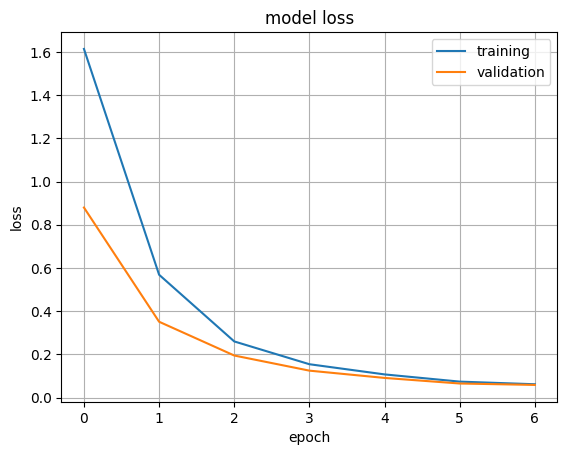

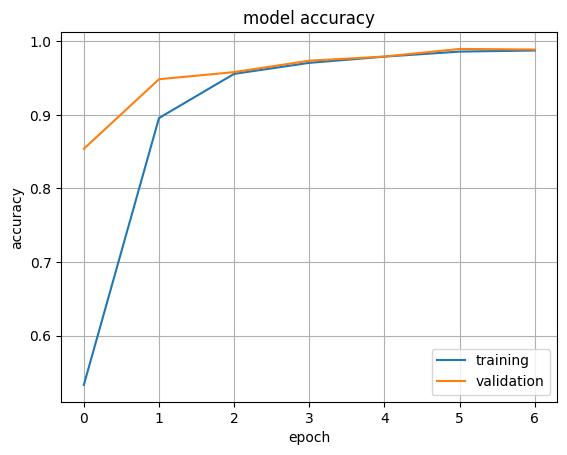

In [8]:
def plot_history(history, key):
    plt.figure()
    plt.plot(history.history[key], label='training')
    plt.plot(history.history[f'val_{key}'], label='validation')
    plt.title(f'model {key}')
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()


plot_history(history, 'loss')
plot_history(history, 'accuracy')

The performance of the trained classifier on the validation examples is summarized in the classification report including various performance metrics

In [9]:
Y_pred = model.predict(X_test)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1)))

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       620
           1       0.96      0.99      0.97       563
           2       1.00      0.98      0.99       594
           3       1.00      0.99      0.99       619
           4       0.99      0.99      0.99       646
           5       0.99      0.98      0.99       582
           6       0.99      1.00      0.99       581
           7       0.99      1.00      0.99       597
           8       0.99      0.99      0.99       604
           9       0.98      0.97      0.98       594

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



**Copyright**

This notebook is provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources).
The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/)
, the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: Sascha Spors, Data driven audio signal processing - Lecture supplementals.